In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from extract_from_configuration import *

In [2]:
device = get_device()

config_name = "test_GP_FNO.yaml"
config_manager = ConfigManager(config_name)
config_manager.load_config()

# Access configurations
data_config     = config_manager.get_data_config()
model_config    = config_manager.get_model_config()

In [3]:
dataset = next(get_dataset(data_config, device))

In [4]:
x, y = dataset[0]
w, n, d = x.shape

In [5]:
train_x = torch.arange(-n, 0, 1, device=device).unsqueeze(-1).float()
test_x = torch.linspace(-n, 0, 51).unsqueeze(-1).to(device)

In [6]:
train_y = x.permute(1, 0, 2)
train_y = train_y.reshape(train_y.shape[0], -1)

In [7]:
x_normalizer = UnitGaussianNormalizer(train_x)
train_x = x_normalizer.encode(train_x)
test_x = x_normalizer.encode(test_x)

In [8]:
y_normalizer = UnitGaussianNormalizer(train_y)
train_y = y_normalizer.encode(train_y)

In [9]:
model = GP(train_x=train_x,
           train_y=train_y,
            model_class = None,
            t = dataset.t,
            **data_config["parameters"],
            **model_config["parameters"]
        )

model.to(device)

GP(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-03)
    (raw_noise_constraint): GreaterThan(1.000E-03)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0-49): 50 x LinearMean()
    )
  )
  (covar_module): MultitaskKernel(
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
    (data_covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [10]:
def train_model(model, optimizer, mll, x_tr, y_tr, num_iterations):
    model.train()
    model.likelihood.train()
    losses_nll = []
    losses_mse = []
    mse_loss = nn.MSELoss()

    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(x_tr)
        loss_nll = -mll(output, y_tr)
        loss_mse = mse_loss(output.mean, y_tr)
        loss = -mll(output, y_tr)
        loss.backward()
        optimizer.step()

        losses_nll.append(loss_nll.item())
        losses_mse.append(loss_mse.item())

        print(f'Iter {i + 1}/{num_iterations} - NLL Loss: {loss_nll.item():.3f} - MSE Loss: {loss_mse.item():.3f}')
    
    return losses_nll, losses_mse

In [40]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

# Train the model
losses_nll, losses_mse = train_model(
    model, 
    optimizer, 
    mll, 
    train_x, 
    train_y, 
    num_iterations=1000)

Iter 1/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 2/1000 - NLL Loss: 0.347 - MSE Loss: 0.420
Iter 3/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 4/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 5/1000 - NLL Loss: 0.346 - MSE Loss: 0.420
Iter 6/1000 - NLL Loss: 0.346 - MSE Loss: 0.420
Iter 7/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 8/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 9/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 10/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 11/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 12/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 13/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 14/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 15/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 16/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 17/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 18/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 19/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 20/1000 - NLL Loss: 0.346 - MSE Loss: 0.419
Iter 21/1000 - NLL Loss: 0.34

# Testing the point

In [41]:
def predict_model(model, x_test, y_normalizer):
    model.eval()
    model.likelihood.eval()

    all_means = []
    all_variances = []

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # for i in range(x_test.shape[0]):
        #     x_i = x_test[i:i+1, :]
        #     observed_pred = model(x_i)
        #     mean_pred_i = observed_pred.mean
        #     var_pred_i = observed_pred.variance

        #     all_means.append(mean_pred_i.cpu().numpy())
        #     all_variances.append(var_pred_i.cpu().numpy())
        predictions = model(x_test)
        all_means = predictions.mean.cpu()
        all_variances = predictions.variance.cpu()


    mean_pred = torch.tensor(np.array(all_means)).squeeze(1)
    var_pred = torch.tensor(np.array(all_variances)).squeeze(1)

    # mean_pred = mean_pred.reshape(x_test.shape[0], -1)
    mean_pred = y_normalizer.decode(mean_pred.detach().cpu())
    # mean_pred = mean_pred.reshape(mean_pred.shape[0], mean_pred.shape[1] * mean_pred.shape[2])

    # var_pred = var_pred.reshape(x_test.shape[0], -1)
    var_pred = y_normalizer.decode(var_pred.detach().cpu())
    # var_pred = var_pred.reshape(var_pred.shape[0], var_pred.shape[1] * var_pred.shape[2])
    var_pred = torch.abs(var_pred)
    
    return mean_pred, var_pred

/home/maurits/miniconda3/envs/nop/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/tmp/ipykernel_118612/3440522872.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  mean_pred = torch.tensor(np.array(all_means)).squeeze(1)
/tmp/ipykernel_118612/3440522872.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes

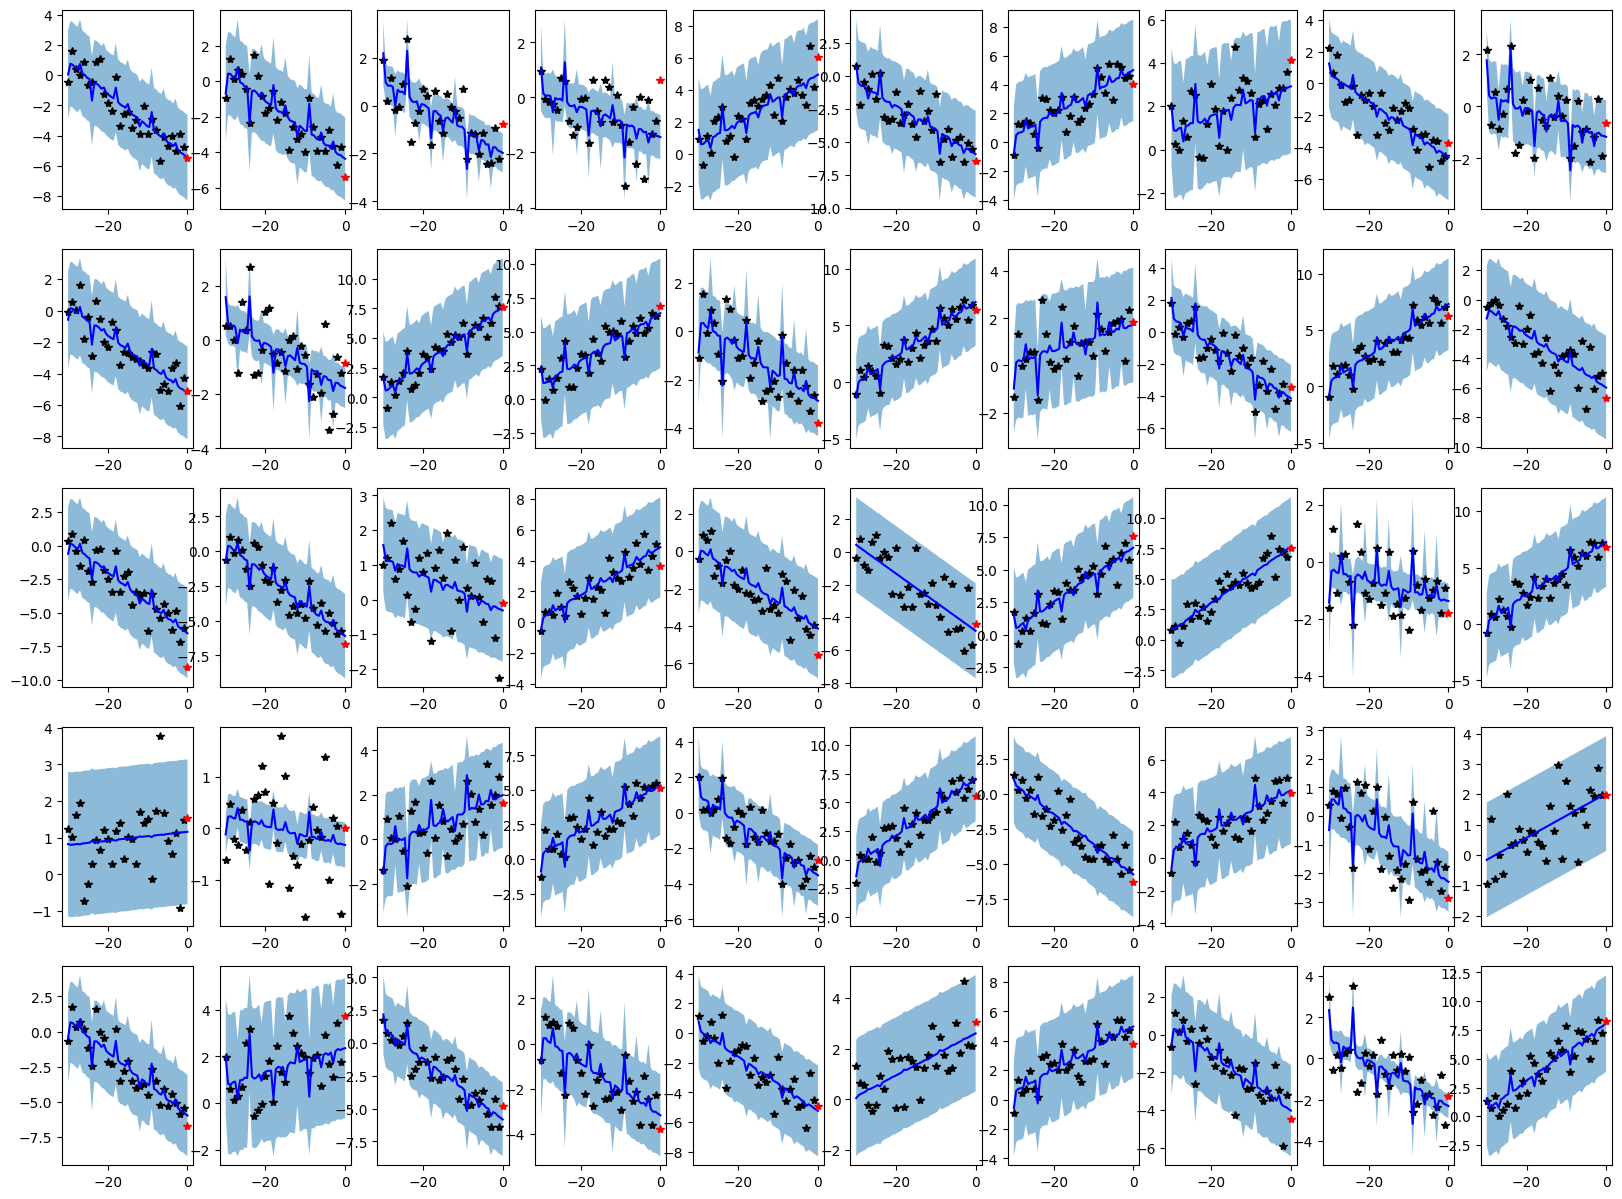

In [46]:
# Set into eval mode
model.eval()
model.likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(dataset.w, dataset.d, figsize = (20, 15))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    
    mean, var = predict_model(model, test_x, y_normalizer)
    std = torch.sqrt(var)
    lower = mean - 2 * std
    upper = mean + 2 * std
    
    # predictions = model.likelihood(model(test_x))
    # mean = predictions.mean
    # lower, upper = predictions.confidence_region()
    
train_x_dec = x_normalizer.decode(train_x.cpu()).squeeze(-1).cpu().numpy()
test_x_dec = x_normalizer.decode(test_x.cpu()).squeeze(-1).cpu().numpy()

train_y_dec = y_normalizer.decode(train_y.cpu())
    
for i, ax in enumerate(axs.flatten()):
    # Plot training data as black stars
    ax.plot(train_x_dec, train_y_dec[:, i].cpu().numpy(), "k*")
    
    # Predictive mean as blue line
    ax.plot(test_x_dec, mean[:, i].cpu().numpy(), 'b')
    
    # Shade in confidence 
    ax.fill_between(test_x_dec, 
                    lower[:, i].cpu().numpy(), 
                    upper[:, i].cpu().numpy(), 
                    alpha=0.5)
    
    # Show actual position
    ax.plot(torch.tensor([0]).cpu(), 
            y.reshape(-1)[i].cpu(), 
            "r*")


In [32]:
y.reshape(-1)[i]

tensor(-5.4455, device='cuda:0')

In [31]:
y_normalizer.encode(torch.tensor([y.reshape(-1)[i]]).cuda())

tensor([-1.5742, -2.0827, -3.8974, -4.6534, -4.9104, -1.1622, -4.8258, -5.6190,
        -1.9168, -4.3587, -1.6282, -3.8917, -4.0443, -4.9402, -3.1251, -3.7889,
        -6.0176, -2.1967, -4.0835, -1.1266, -1.0944, -1.2683, -5.7800, -4.8834,
        -2.2781, -1.6918, -4.2382, -4.3037, -4.7292, -3.9485, -7.1995, -6.4196,
        -4.9054, -4.5643, -2.6535, -3.5780, -1.4212, -5.3668, -3.4767, -5.9807,
        -1.3331, -6.0770, -1.4251, -2.8790, -1.5326, -5.9499, -5.0262, -2.2786,
        -3.2330, -3.8837], device='cuda:0')

In [17]:
torch.sqrt(var).shape

torch.Size([51, 50])